In [1]:
# import pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# import other libraries
import tqdm
import matplotlib.pyplot as plt
import numpy as np

# import specific functions
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from torchvision import datasets, transforms

# import custom functions
from interpolate import interpolate

In [2]:
# choose whether to retrain the mnist model and save it or use the saved one
TRAIN = True
SAVE = True

# path to the model saves
PATH = './models/'

## Define basic Variational Autoencoder and necessary routines

In [3]:
# variational autoencoder skeleton

class VAE(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(VAE, self).__init__()

        # define architecture of the vae
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size
        
        # construct the encoder, and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        #define loss function and optimizer
        self.mse_loss_function = nn.MSELoss(reduction='mean')
        self.mse_weight = 1000

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def loss_function(self, x, x_hat, mu, log_var):
        # loss function
        mse_loss = self.mse_loss_function(x, x_hat)
        kl_loss = torch.mean(-0.5 * sum(1 + log_var - torch.square(mu) - torch.square(torch.exp(log_var))))
        return self.mse_weight* mse_loss +  kl_loss

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Linear(self.input_size, self.hidden_layer_size))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size, self.bottleneck_size*2))

        return encoder
    
    def reparameterise(self, mu, log_var):
        # reparameterise
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Linear(self.hidden_layer_size, self.input_size))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        z = self.reparameterise(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var
    

In [4]:
# define training loop

def train_vae(model, X_train, X_val, n_epochs=10, batch_size=32, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }

    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)
    
    for epoch in pbar:
        # training
        model.train()
        train_loss = 0
        for i in tqdm.tqdm(range(0, X_train.shape[0], batch_size)):
            batch = X_train[i:i+batch_size]
            model.optimizer.zero_grad()
            output, mu, log_var = model(batch)
            loss = model.loss_function(batch, output, mu, log_var)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= X_train.shape[0]
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, X_val.shape[0], batch_size):
                batch = X_val[i:i+batch_size]
                output, mu, log_var = model(batch)
                loss = model.loss_function(batch, output, mu, log_var)
                val_loss += loss.item()
            val_loss /= X_val.shape[0]
            loss_history['val'].append(val_loss)

        #print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
        
    return loss_history

In [12]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

## Use the VAE for a 2D dataset

In [27]:
dataset_size = 5000

# load data

dataset = make_moons(n_samples=dataset_size, noise=0.1)[0]

#split into train and val

X_train, X_val = train_test_split(dataset, test_size=0.2)
X_val, X_test = train_test_split(X_val, test_size=0.5)

In [32]:
# architecture of the vae

INPUT_SIZE = 2
BOTTLENECK_SIZE = 1
HIDDEN_SIZE = 64
HIDDEN_LAYERS = 5

vae_moons = VAE(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, BOTTLENECK_SIZE)

100%|██████████| 125/125 [00:00<00:00, 178.57it/s]:  96%|█████████▌| 24/25 [00:16<00:00,  1.42it/s]
Epoch: 25/25, train loss: 3.3992, val loss: 3.9052: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


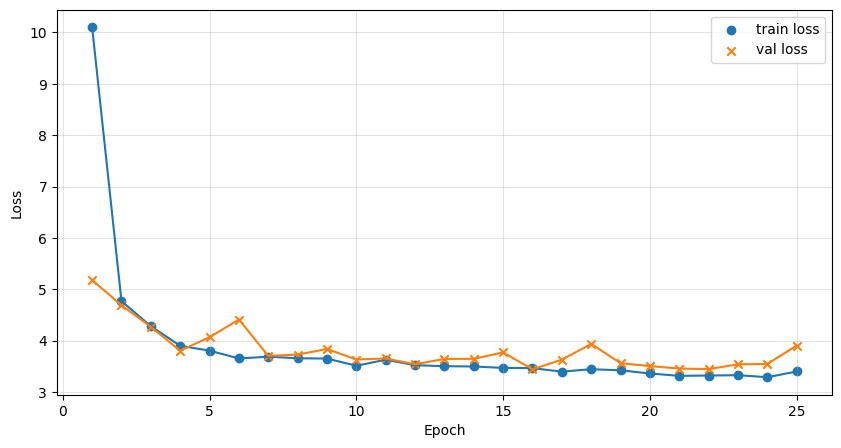

In [33]:
# train the vae

loss_history_moons = train_vae(vae_moons, torch.Tensor(X_train), torch.Tensor(X_val), n_epochs=25, batch_size=32)

# plot loss history

plot_loss_history(loss_history_moons)

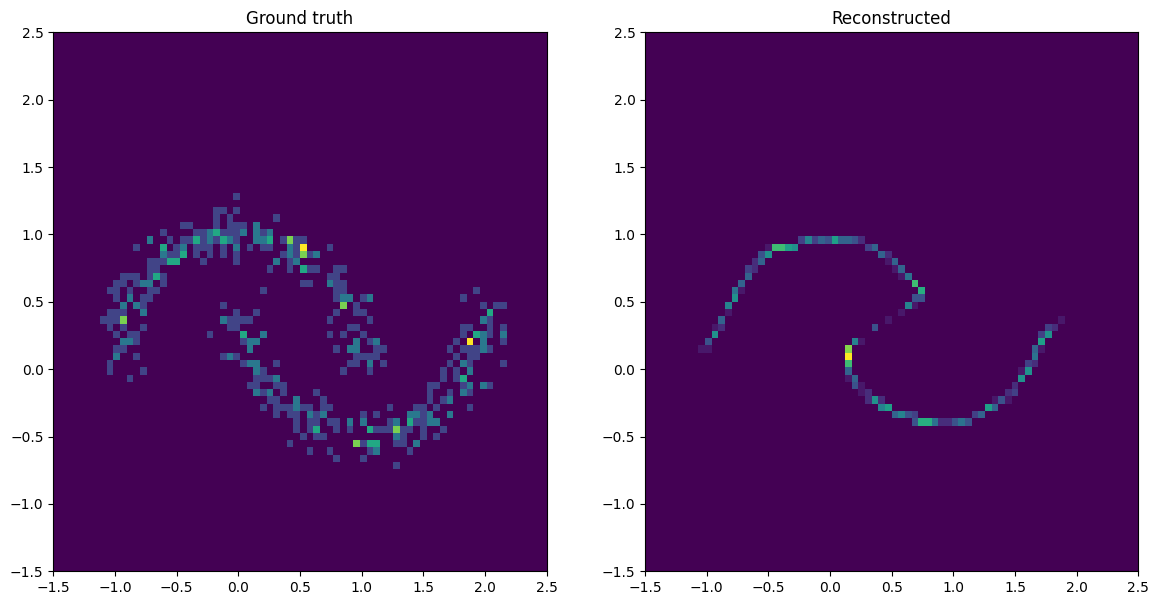

In [40]:
# compare ground truth and reconstructed data of test set
vae_moons.eval()
reconstructed_moons, _, _ = vae_moons(torch.Tensor(X_test))
reconstructed_moons = reconstructed_moons.detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed');

## More complex example: MNIST

In [6]:
# construct convolutional vae for mnist data

class ConvVAE(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(ConvVAE, self).__init__()

        # define architecture of the vae
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size

        self.mnist_size = 28
        
        # construct the encoder, and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        #define loss function and optimizer
        self.mse_loss_function = nn.MSELoss(reduction='mean')
        self.mse_weight = 1000

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def loss_function(self, x, x_hat, mu, log_var):
        # loss function
        mse_loss = self.mse_loss_function(x, x_hat)
        kl_loss = torch.mean(-0.5 * sum(1 + log_var - torch.square(mu) - torch.square(torch.exp(log_var))))
        return self.mse_weight* mse_loss +  kl_loss

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Conv2d(self.input_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('flatten', nn.Flatten())
        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size * self.mnist_size * self.mnist_size, self.bottleneck_size*2))
        
        return encoder
    
    def reparameterise(self, mu, log_var):
        # reparameterise
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size * self.mnist_size * self.mnist_size))
        decoder.add_module('reshape', nn.Unflatten(1, (self.hidden_layer_size, self.mnist_size, self.mnist_size)))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Conv2d(self.hidden_layer_size, self.input_size, kernel_size=3, stride=1, padding=1))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        z = self.reparameterise(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var
        

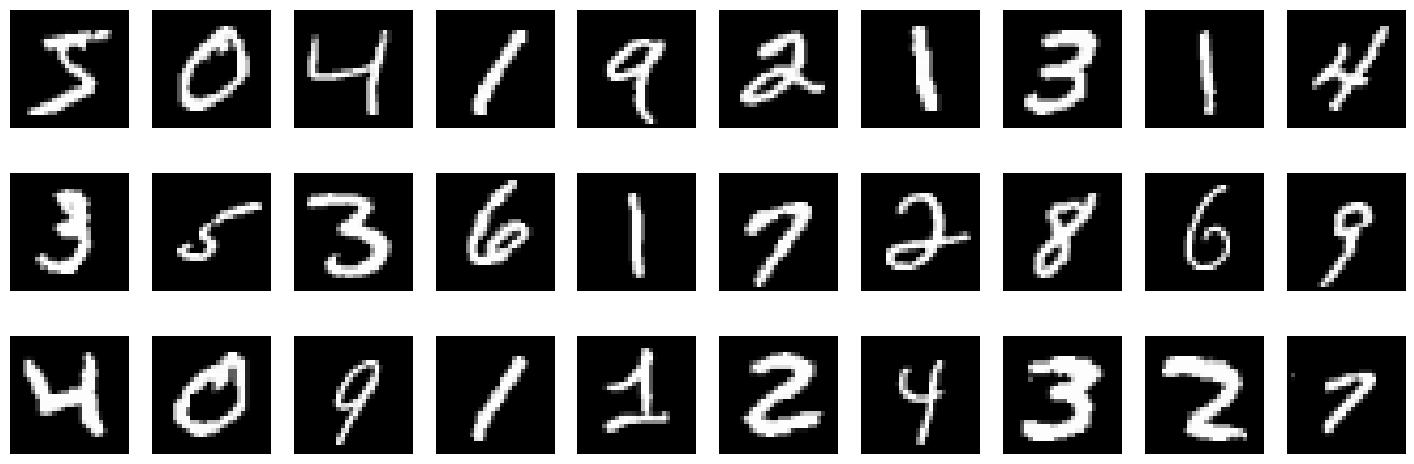

In [7]:
# get MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_test_data, mnist_val_data = train_test_split(mnist_test_data, test_size=0.5)

mnist_train = torch.stack([x for x, _ in mnist_train_data])
mnist_test = torch.stack([x for x, _ in mnist_test_data])
mnist_val = torch.stack([x for x, _ in mnist_val_data])

mnist_test_labels = torch.Tensor([y for _, y in mnist_test_data])

# visualise data

fig, ax = plt.subplots(3, 10, figsize=(18, 6))

for i in range(3):
    for j in range(10):
        ax[i, j].imshow(mnist_train[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')

100%|██████████| 1875/1875 [00:40<00:00, 46.69it/s]  98%|█████████▊| 49/50 [1:36:57<00:54, 54.44s/it]
Epoch: 50/50, train loss: 7.4287, val loss: 7.4480: 100%|██████████| 50/50 [1:37:37<00:00, 117.16s/it]


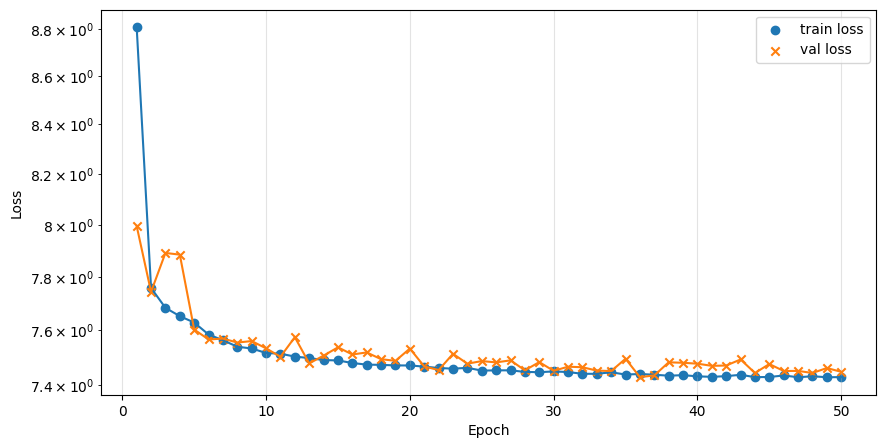

In [24]:
# train variational autoencoder on MNIST dataset

INPUT_SIZE = 1
BOTTLENECK_SIZE = 2
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3


if TRAIN:
    conv_vae_mnist = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist = train_vae(conv_vae_mnist, mnist_train, mnist_val, n_epochs=50, batch_size=32)
    plot_loss_history(loss_history_mnist)
    if SAVE:
        torch.save(conv_vae_mnist.state_dict(), PATH + 'conv_vae_mnist.pt')
        np.save(PATH + 'loss_history_vae_mnist.npy', loss_history_mnist)

else:
    # load pretrained model
    conv_vae_mnist = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_vae_mnist.load_state_dict(torch.load(PATH + 'conv_vae_mnist.pt'))
    loss_history_mnist = np.load(PATH + 'loss_history_vae_mnist.npy', allow_pickle=True).item()
    plot_loss_history(loss_history_mnist)


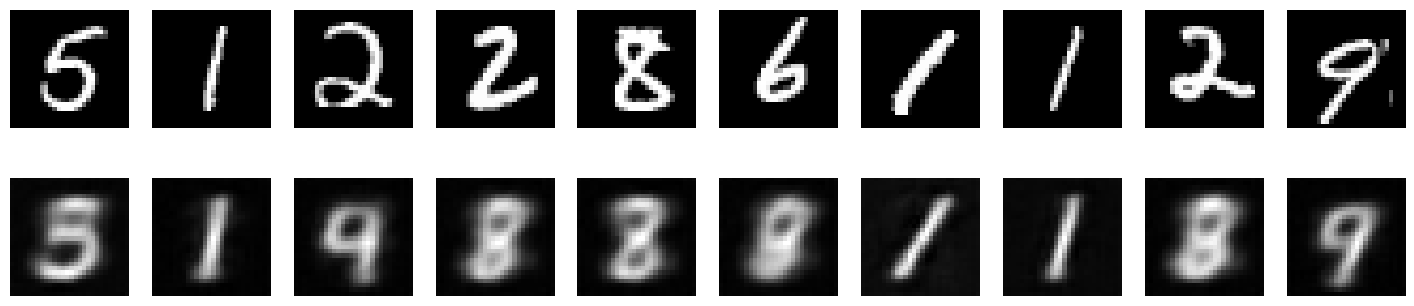

In [25]:
# test reconstruction ability

conv_vae_mnist.eval()

with torch.no_grad():
    mnist_test_recon, _, _ = conv_vae_mnist(mnist_test)

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(mnist_test_recon[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')

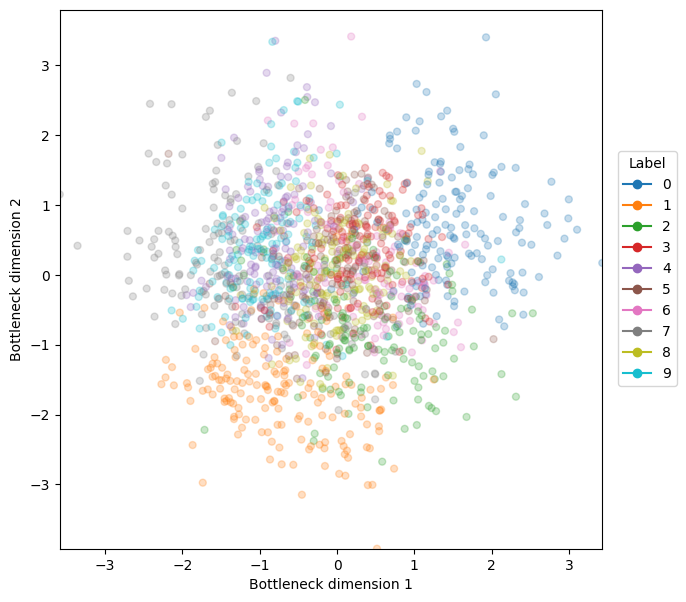

In [22]:
# visualise bottleneck layer with respect to the labels
conv_vae_mnist.eval()

bottleneck_mnist = conv_vae_mnist.encoder(mnist_test)
mu, log_var = torch.chunk(bottleneck_mnist, 2, dim=-1)
bottleneck_mnist = conv_vae_mnist.reparameterise(mu, log_var).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(bottleneck_mnist[:1500, 0], bottleneck_mnist[:1500, 1], c=mnist_test_labels[:1500], cmap='tab10', alpha=0.25, marker='.', s=100)

ax.set_xlabel('Bottleneck dimension 1')
ax.set_ylabel('Bottleneck dimension 2')

legend_handeles = []   
for i in range(10):
    legend_handeles.append(plt.Line2D([0], [0], marker='o', color=plt.cm.tab10.colors[i], label=str(i)))

ax.legend(handles=legend_handeles, title='Label', loc='upper right', bbox_to_anchor=(1.15, 0.75))

ax.set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
ax.set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])]);

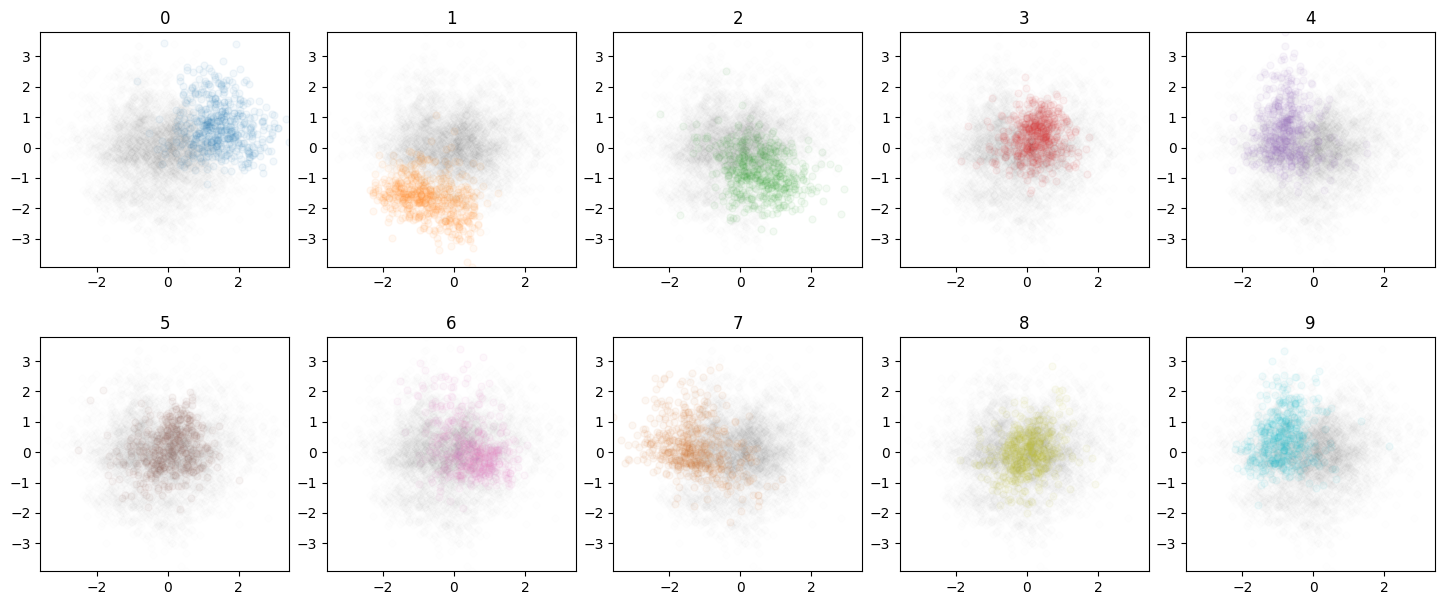

In [23]:
# make subplots for each digit

fig, ax = plt.subplots(2, 5, figsize=(18, 7))

for i in range(10):
    for j in range(10):
        if j != i:
            ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == j, 0], bottleneck_mnist[mnist_test_labels == j, 1], color='black', alpha=0.005, marker='.', s=100)

    if i != 7:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color=plt.cm.tab10.colors[i], alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))
    else:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color='chocolate', alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))

    ax[i//5, i%5].set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
    ax[i//5, i%5].set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])])

    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.15)
    

## So, what about data generation now?

In [ ]:
# Rethink the generation parts...

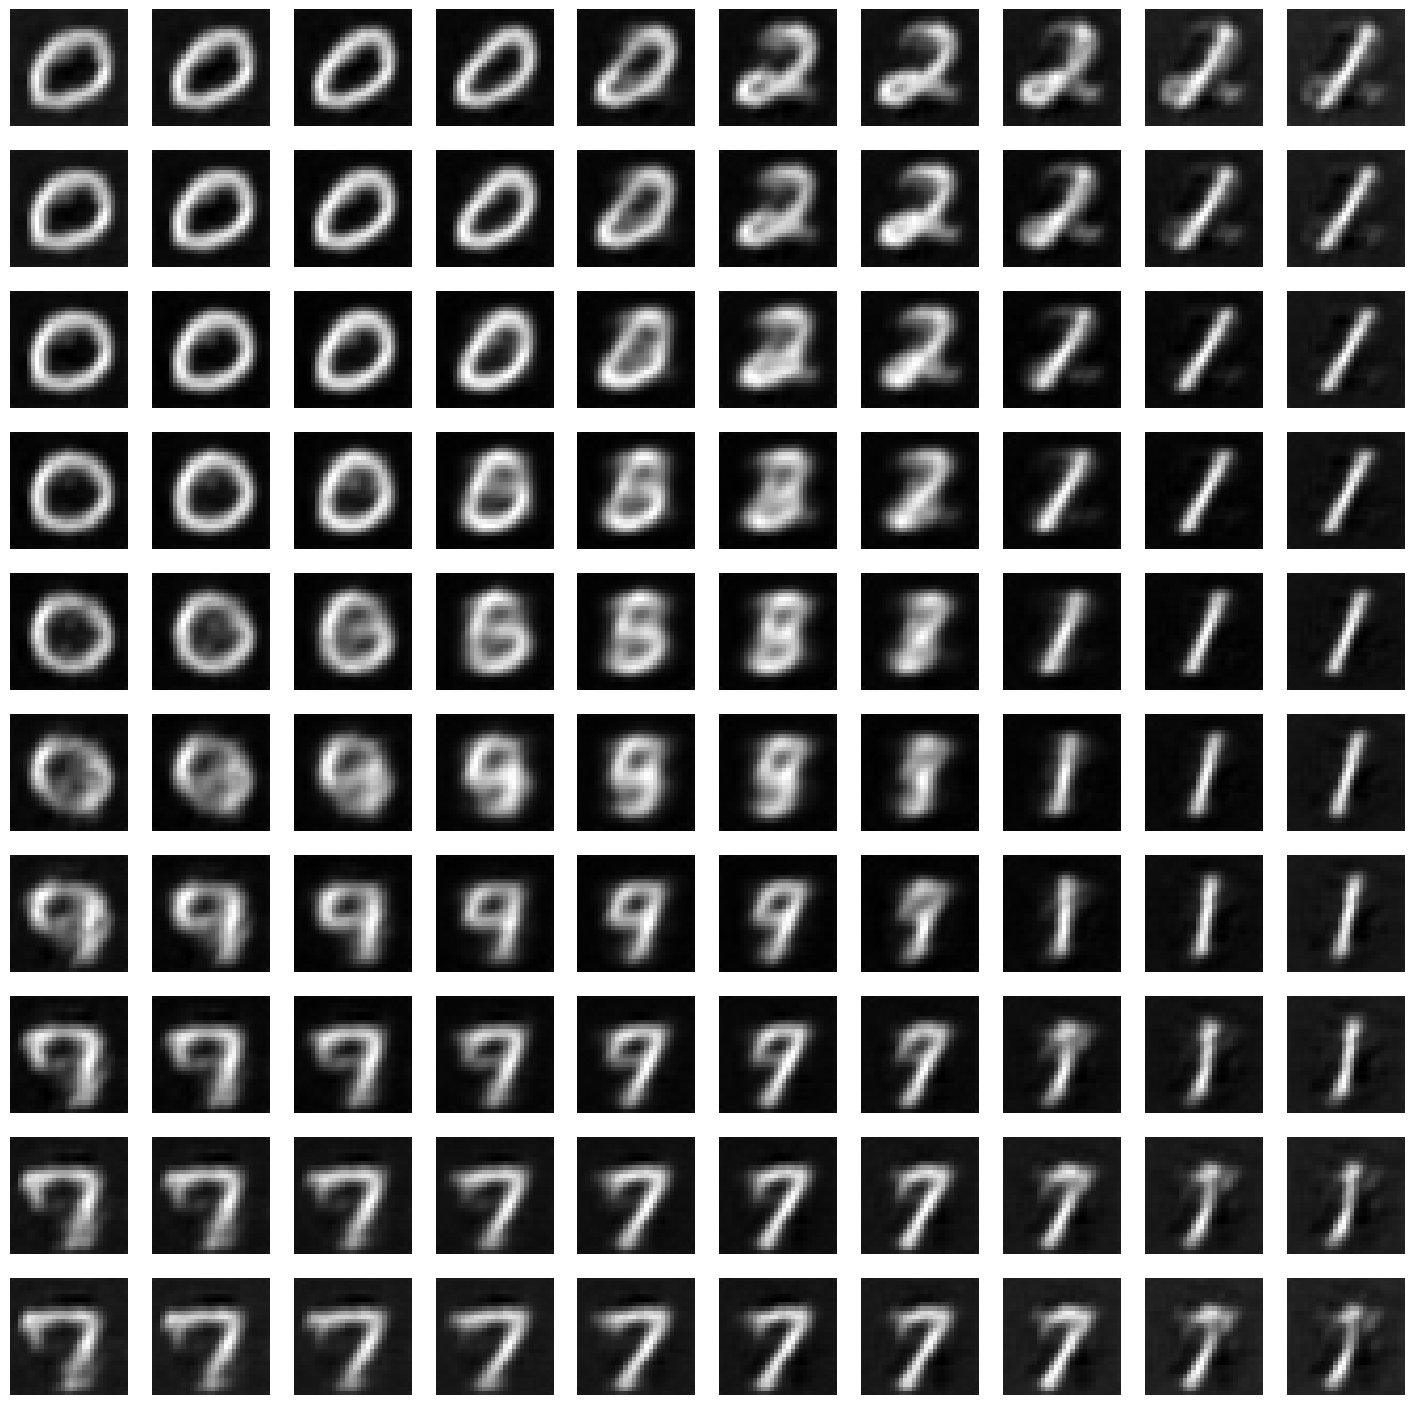

In [56]:
# generate 100 samples in a grid from -3 to 3 in both dimensions

x = np.linspace(-3, 3, 10)
y = np.linspace(3, -3, 10)

grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

# generate samples from the grid

grid = torch.Tensor(grid)
with torch.no_grad():
    grid_recon = conv_vae_mnist.decoder(grid)
    
grid_recon = grid_recon.detach().numpy()

# plot the grid

fig, ax = plt.subplots(10, 10, figsize=(18, 18))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(grid_recon[j*10 + i].squeeze(), cmap='gray')
        ax[i, j].axis('off')



h:\Uni\Master\Semester 2\SciML\SciML-Seminar\interpolate.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  interpolated_points = torch.Tensor(interpolated_points)
MovieWriter imagemagick unavailable; using Pillow instead.


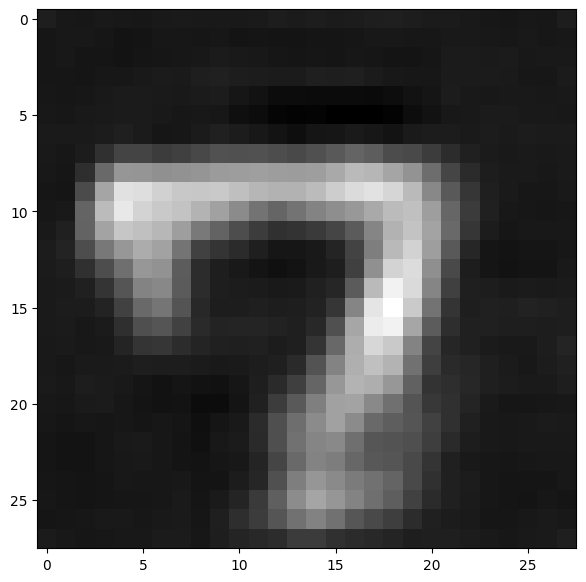

In [18]:
anim = interpolate(conv_vae_mnist, np.array([[-3, -3], [3, 3], [-3, 3], [3, -3], [-3, -3]]), 0.1, name='interpolation_vae.gif')

100%|██████████| 1875/1875 [00:48<00:00, 38.68it/s]  98%|█████████▊| 49/50 [37:21<00:48, 48.53s/it]
Epoch: 50/50, train loss: 4.3381, val loss: 4.4322: 100%|██████████| 50/50 [38:10<00:00, 45.82s/it]


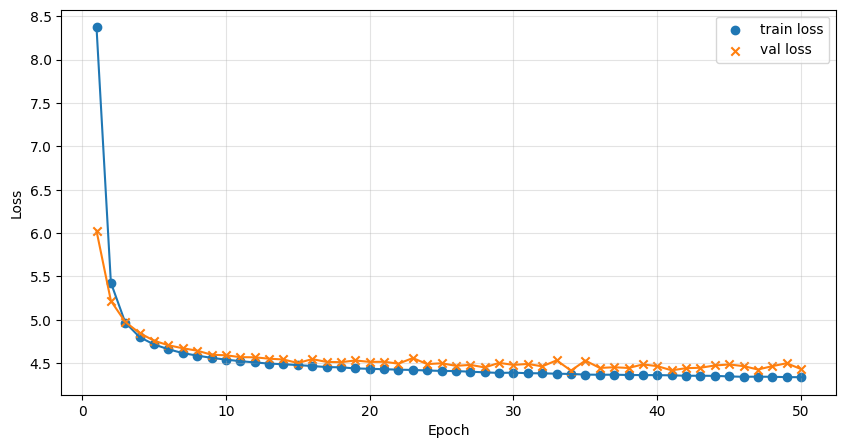

In [10]:
# train vae with bottleneck size 8

INPUT_SIZE = 1
BOTTLENECK_SIZE = 8
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3


if TRAIN:
    conv_vae_mnist_8 = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist_8 = train_vae(conv_vae_mnist_8, mnist_train, mnist_val, n_epochs=50, batch_size=32)
    plot_loss_history(loss_history_mnist_8)
    if SAVE:
        torch.save(conv_vae_mnist_8.state_dict(), 'conv_vae_mnist_8.pt')
        np.save('loss_history_vae_mnist_8.npy', loss_history_mnist_8)

else:
    # load pretrained model
    conv_vae_mnist_8 = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_vae_mnist_8.load_state_dict(torch.load('conv_vae_mnist_8.pt'))
    loss_history_mnist_8 = np.load('loss_history_vae_mnist_8.npy', allow_pickle=True).item()
    plot_loss_history(loss_history_mnist_8)

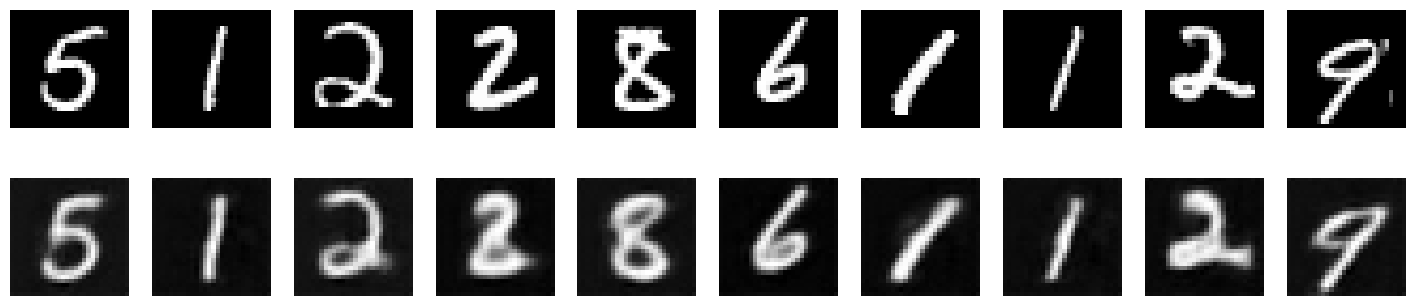

In [11]:
# look at reconstruction ability

conv_vae_mnist_8.eval()

with torch.no_grad():
    mnist_test_recon_8, _, _ = conv_vae_mnist_8(mnist_test)

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(mnist_test_recon_8[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')

MovieWriter imagemagick unavailable; using Pillow instead.


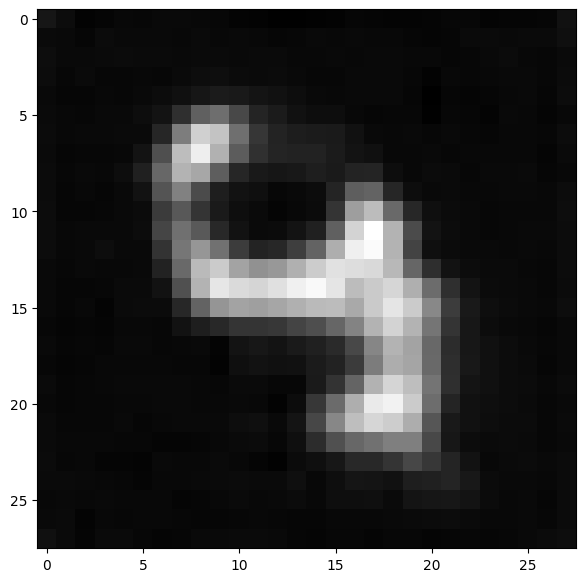

In [21]:
anim = interpolate(conv_vae_mnist_8, np.array([[-1, -1, 1, 1, -1, -1, 1, 1], [-1, 1, 1, -1, -1, 1, 1, -1], [1, 1, 1, 1, 1, 1, 1, 1], [1, -1, 1, 1, 1, -1, 1, 1], [-1, -1, 1, 1, -1, -1, 1, 1]]), 0.1, name='interpolation_vae_8.gif')